In [112]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [113]:
np.random.seed(0)

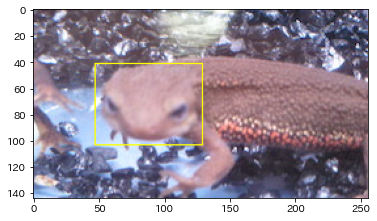

In [117]:
# read image
img = cv2.imread("../assets/imori_1.jpg")
H, W, C = img.shape

# Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

gt = np.array((47, 41, 129, 103), dtype=np.float32)

rect = cv2.rectangle(img, (gt[0], gt[1]), (gt[2], gt[3]), (0,255,255), 1)

plt.imshow(img[:,:,::-1])

In [118]:
def iou(a, b):
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    iou_x1 = np.maximum(a[0], b[0])
    iou_y1 = np.maximum(a[1], b[1])
    iou_x2 = np.minimum(a[2], b[2])
    iou_y2 = np.minimum(a[3], b[3])
    iou_w = max(iou_x2 - iou_x1, 0)
    iou_h = max(iou_y2 - iou_y1, 0)
    area_iou = iou_w * iou_h
    iou = area_iou / (area_a + area_b - area_iou)
    return iou

In [119]:
def hog(gray):
    h, w = gray.shape
    # Magnitude and gradient
    gray = np.pad(gray, (1, 1), 'edge')

    gx = gray[1:h+1, 2:] - gray[1:h+1, :w]
    gy = gray[2:, 1:w+1] - gray[:h, 1:w+1]
    gx[gx == 0] = 0.000001

    mag = np.sqrt(gx ** 2 + gy ** 2)
    gra = np.arctan(gy / gx)
    gra[gra<0] = np.pi / 2 + gra[gra < 0] + np.pi / 2

    # Gradient histogram
    gra_n = np.zeros_like(gra, dtype=np.int)

    d = np.pi / 9
    for i in range(9):
        gra_n[np.where((gra >= d * i) & (gra <= d * (i+1)))] = i

    N = 8
    HH = h // N
    HW = w // N
    Hist = np.zeros((HH, HW, 9), dtype=np.float32)
    for y in range(HH):
        for x in range(HW):
            for j in range(N):
                for i in range(N):
                    Hist[y, x, gra_n[y*4+j, x*4+i]] += mag[y*4+j, x*4+i]

    ## Normalization
    C = 3
    eps = 1
    for y in range(HH):
        for x in range(HW):
            #for i in range(9):
            Hist[y, x] /= np.sqrt(np.sum(Hist[max(y-1,0):min(y+2, HH), max(x-1,0):min(x+2, HW)] ** 2) + eps)

    return Hist

In [120]:
def resize(img, h, w):
    _h, _w  = img.shape
    ah = 1. * h / _h
    aw = 1. * w / _w
    y = np.arange(h).repeat(w).reshape(w, -1)
    x = np.tile(np.arange(w), (h, 1))
    y = (y / ah)
    x = (x / aw)

    ix = np.floor(x).astype(np.int32)
    iy = np.floor(y).astype(np.int32)
    ix = np.minimum(ix, _w-2)
    iy = np.minimum(iy, _h-2)

    dx = x - ix
    dy = y - iy

    out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]
    out[out>255] = 255

    return out

In [121]:
class NN:
    def __init__(self, ind=2, w=64, w2=64, outd=1, lr=0.1):
        self.w1 = np.random.normal(0, 1, [ind, w])
        self.b1 = np.random.normal(0, 1, [w])
        self.w2 = np.random.normal(0, 1, [w, w2])
        self.b2 = np.random.normal(0, 1, [w2])
        self.wout = np.random.normal(0, 1, [w2, outd])
        self.bout = np.random.normal(0, 1, [outd])
        self.lr = lr

    def forward(self, x):
        self.z1 = x
        self.z2 = sigmoid(np.dot(self.z1, self.w1) + self.b1)
        self.z3 = sigmoid(np.dot(self.z2, self.w2) + self.b2)
        self.out = sigmoid(np.dot(self.z3, self.wout) + self.bout)
        return self.out

    def train(self, x, t):
        # backpropagation output layer
        #En = t * np.log(self.out) + (1-t) * np.log(1-self.out)
        En = (self.out - t) * self.out * (1 - self.out)
        grad_wout = np.dot(self.z3.T, En)
        grad_bout = np.dot(np.ones([En.shape[0]]), En)
        self.wout -= self.lr * grad_wout
        self.bout -= self.lr * grad_bout

        # backpropagation inter layer
        grad_u2 = np.dot(En, self.wout.T) * self.z3 * (1 - self.z3)
        grad_w2 = np.dot(self.z2.T, grad_u2)
        grad_b2 = np.dot(np.ones([grad_u2.shape[0]]), grad_u2)
        self.w2 -= self.lr * grad_w2
        self.b2 -= self.lr * grad_b2

        grad_u1 = np.dot(grad_u2, self.w2.T) * self.z2 * (1 - self.z2)
        grad_w1 = np.dot(self.z1.T, grad_u1)
        grad_b1 = np.dot(np.ones([grad_u1.shape[0]]), grad_u1)
        self.w1 -= self.lr * grad_w1
        self.b1 -= self.lr * grad_b1

In [122]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [123]:
# crop and create database

Crop_num = 200
L = 60
H_size = 32
F_n = ((H_size // 8) ** 2) * 9

db = np.zeros((Crop_num, F_n+1))

In [124]:
for i in range(Crop_num):
    x1 = np.random.randint(W-L)
    y1 = np.random.randint(H-L)
    x2 = x1 + L
    y2 = y1 + L
    crop = np.array((x1, y1, x2, y2))

    _iou = iou(gt, crop)

    if _iou >= 0.5:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 1)
        label = 1
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 1)
        label = 0

    crop_area = gray[y1:y2, x1:x2]
    crop_area = resize(crop_area, H_size, H_size)
    _hog = hog(crop_area)

    db[i, :F_n] = _hog.ravel()
    db[i, -1] = label

In [125]:
## train neural network
nn = NN(ind=F_n, lr=0.01)
for i in range(10000):
    nn.forward(db[:, :F_n])
    nn.train(db[:, :F_n], db[:, -1][..., None])

In [126]:
# read detect target image
img2 = cv2.imread("../assets/imori_many.jpg")
H2, W2, C2 = img2.shape

# Grayscale
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# [h, w]
recs = np.array(((42, 42), (56, 56), (70, 70)), dtype=np.float32)

detects = np.ndarray((0, 5), dtype=np.float32)

In [127]:
# sliding window
for y in range(0, H2, 4):
    for x in range(0, W2, 4):
        for rec in recs:
            dh = int(rec[0] // 2)
            dw = int(rec[1] // 2)
            x1 = max(x-dw, 0)
            x2 = min(x+dw, W2)
            y1 = max(y-dh, 0)
            y2 = min(y+dh, H2)
            region = gray2[max(y-dh,0):min(y+dh,H2), max(x-dw,0):min(x+dw,W2)]
            region = resize(region, H_size, H_size)
            region_hog = hog(region).ravel()

            score = nn.forward(region_hog)
            if score >= 0.7:
                cv2.rectangle(img2, (x1, y1), (x2, y2), (0,0,255), 1)
                detects = np.vstack((detects, np.array((x1, y1, x2, y2, score))))

print(detects)

[[31 0 73 21 array([0.86555683])]
 [24 0 80 28 array([0.82803662])]
 [47 0 89 21 array([0.74374336])]
 [165 0 235 43 array([0.78514116])]
 [165 0 235 47 array([0.92573025])]
 [169 0 239 47 array([0.73666401])]
 [165 0 235 51 array([0.85263275])]
 [51 0 93 41 array([0.79580527])]
 [168 0 224 56 array([0.85951811])]
 [43 15 85 57 array([0.92447786])]
 [177 37 247 107 array([0.81790931])]
 [96 72 152 128 array([0.90400246])]
 [100 72 156 128 array([0.98218137])]
 [29 69 99 139 array([0.73137595])]
 [104 76 160 132 array([0.92644467])]
 [105 69 175 139 array([0.7258011])]
 [97 73 167 143 array([0.84493561])]
 [105 73 175 143 array([0.70926038])]
 [4 84 60 140 array([0.71762931])]
 [97 77 167 144 array([0.7043197])]
 [63 115 105 144 array([0.74044953])]]


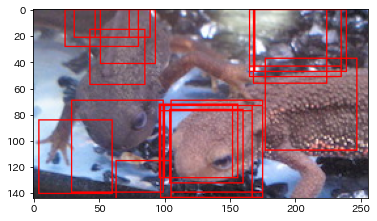

In [128]:
plt.imshow(img2[:,:,::-1])